In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline
# %matplotlib tk

Create a distribution of points in an elliptical annulus

(-1.0, 6.0)

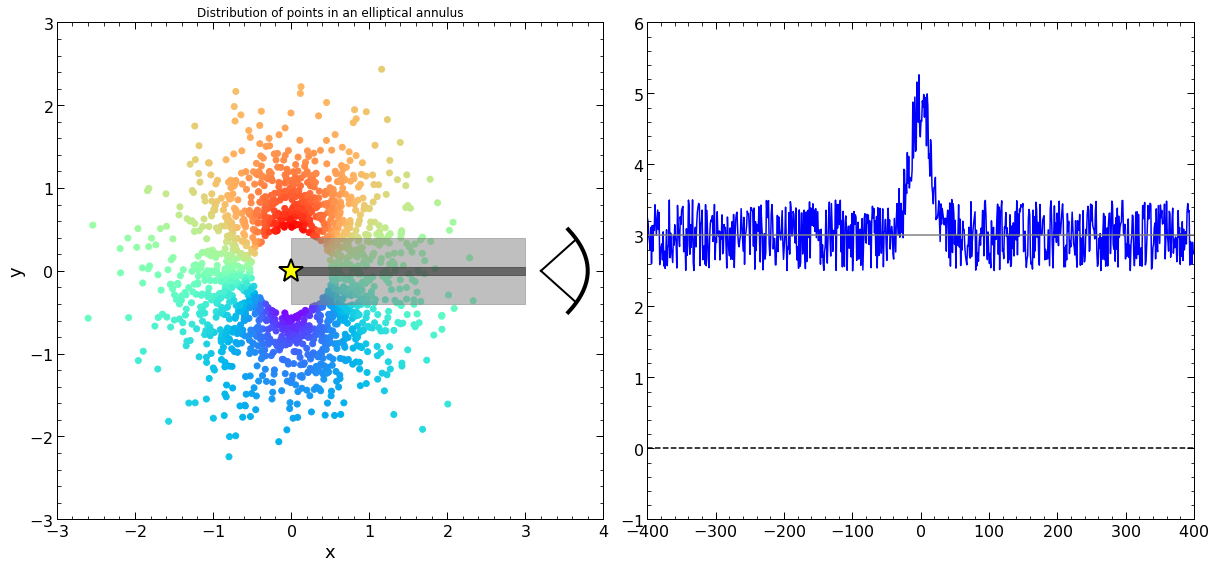

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Define the parameters of the circular annulus
r1, r2 = 0.51, 6 # inner and outer radii of the annulus

# Generate random points within the annulus
n_points = 2000
theta = 2*np.pi*np.random.rand(n_points)
# r = np.sqrt(np.random.uniform(r1**2, r2**2, n_points))
r = np.sqrt(np.random.exponential(1, n_points))
x = r*np.cos(theta)
y = r*np.sin(theta)

# mask points outside the annulus:
x[r<r1] = 0
y[r<r1] = 0
x[r>r2] = 0
y[r>r2] = 0

r = r[x!=0]
theta = theta[x!=0]
x = x[x!=0]
y = y[y!=0]

# Define angular velocity of objects
omega = np.sqrt(1/r**3)

# Compute the color of each point based on its position in the ellipse
v = omega*r
vx = v*np.sin(theta)
color = vx

# Compute emission spectrum of each blob

# Parameters for each cloud:

def gaussian(amp, lw, offset, cont, x):
    return amp/(lw*(2*np.pi)**0.5) * np.exp(-0.5*(x-offset)**2 / lw**2) + cont

velRange = np.linspace(-400, 400, int(800/1))
spec = gaussian(70, 15, 0, 3, velRange)
noise = np.random.uniform(-0.5, 0.5, size=len(spec))
realspec = spec+noise

# Create a scatter plot of the points with colors
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(17, 8))
ax1.scatter(x, y, c=color, cmap='rainbow')
ax1.fill_between(x=[0, 3], y1=[0.05, 0.05], y2=[-0.05, -0.05], color='k', alpha=0.7)
ax1.fill_between(x=[0, 3], y1=[0.4, 0.4], y2=[-0.4, -0.4], color='grey', alpha=0.5)
yp = np.linspace(-0.5, 0.5, 20)
xp = -yp**2 + 3.8
ax1.plot(xp, yp, ls='-', c='k', lw=4)
ax1.plot([3.65, 3.2], [0.38, 0], ls='-', lw=2, c='k')
ax1.plot([3.65, 3.2], [-0.38, 0], ls='-', lw=2, c='k')

# Add labels and title
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim(-3, 4)
ax1.set_ylim(-3, 3)
ax1.set_title('Distribution of points in an elliptical annulus')

# Add a central point source
ax1.plot(0, 0, '*', ms=25, color='yellow', mec='k', mew=2)

# Add a spectrum plot
ax2.plot(velRange, realspec, ls='-', c='b')
ax2.axhline(y=3, c='grey', ls='-')
ax2.axhline(y=0, c='k', ls='--')
ax2.set_xlim(-400, 400)
ax2.set_ylim(-1, 6)

In [108]:
import matplotlib.animation as animation

N = len(x)   # number of objects in the disk

# Define time step and duration of simulation
dt = 0.01   # in years
t_max = 10   # in years

# Define arrays to store positions of objects
x_arr = np.zeros((N, int(t_max/dt)))
y_arr = np.zeros((N, int(t_max/dt)))

for i in range(int(t_max/dt)):

    x = r * np.cos(theta + omega*i*dt)
    y = r * np.sin(theta + omega*i*dt)

    # Store positions and velocities in arrays
    x_arr[:,i] = x
    y_arr[:,i] = y
    
    # redefine color for proper red/blueshift
    v = omega*r
    vx = v*np.sin(theta + omega*i*dt)
    color = vx

    fig, ax1, ax2 = plt.subplots(1,2, figsize=(9, 8))
    ax1.scatter(x, y, c=color, cmap='rainbow')
    ax1.plot(0, 0, '*', ms=25, color='yellow', mec='k', mew=2)
    ax1.fill_between(x=[0, 2.5], y1=[0.05, 0.05], y2=[-0.05, -0.05], color='k', alpha=0.7)
    ax1.fill_between(x=[0, 2.5], y1=[0.4, 0.4], y2=[-0.4, -0.4], color='grey', alpha=0.5)
    yp = np.linspace(-0.5, 0.5, 20)
    xp = -yp**2 + 3.8
    ax1.plot(xp, yp, ls='-', c='k', lw=4)
    ax1.plot([3.65, 3.2], [0.38, 0], ls='-', lw=2, c='k')
    ax1.plot([3.65, 3.2], [-0.38, 0], ls='-', lw=2, c='k')
    ax1.set_xlim(-3,4)
    ax1.set_ylim(-3,3)
    plt.savefig('./figs/frame%s.png'%str(i))
    plt.clf()
    plt.close()